In [4]:

#coding: utf-8
from __future__ import print_function

import warnings
warnings.simplefilter("ignore")
import librosa
import time
import os
import sys 
import wave
import pickle
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from StringIO import StringIO
from IPython.display import Audio
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.signal import spectrogram
import tensorflow as tf
from tensorflow.contrib.layers import conv2d, batch_norm, max_pool2d, fully_connected, flatten, dropout, avg_pool2d, l2_regularizer


Populating the interactive namespace from numpy and matplotlib


# Get the Data

Датасет для контеста помещен вот здесь: https://yadi.sk/d/3jmeVCfSwTKgm (внимание! файл весит 3,5 Гб)


Он распаковывается в папку "musicdata". Все пути в этом ноутбуке будут относительно этой папки: "./musicdata/\*". 

Вы можете изменить базовый путь, как вам удобно.

In [5]:
BP = "../../musicdata/"

# Just a Sound

Для начала попробуем поработать со звуком - послушайте любой трек, постройте график сырых данных и спектрограмму.

In [6]:
sound_file = os.path.join(BP, "audiosamples", "short_206377.wav")
#sound_file = "./short_206626.wav"
rate, signal = read(sound_file)

print(len(signal))

Audio(url=sound_file)

220500


# Sound as 1D-Signal

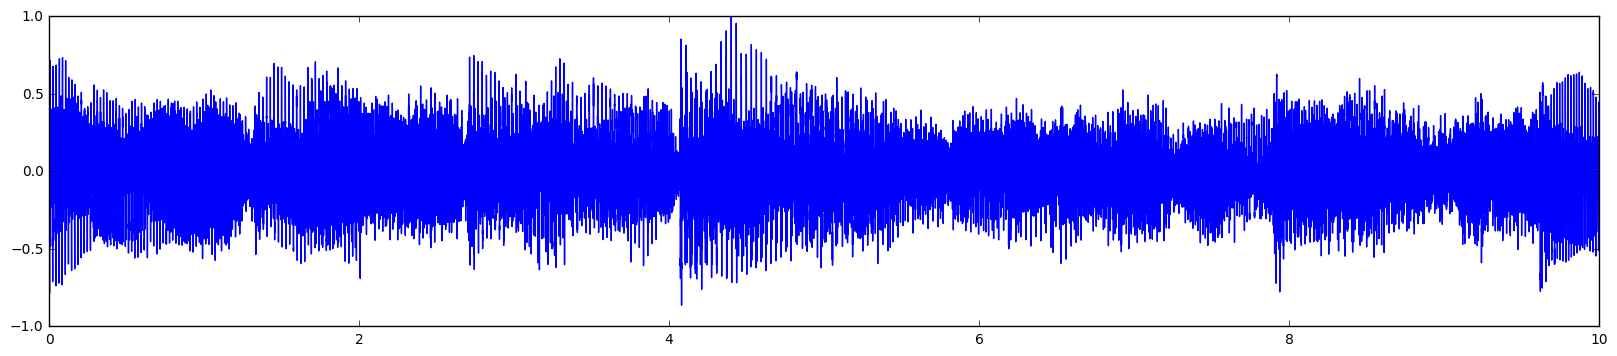

In [7]:
plt.figure(figsize=(20,4))
ts = np.linspace(0, len(signal) / rate, len(signal))
plt.plot(ts, signal)
plt.show()

# Sound as 2D-Signal

Нашу цель слелать из предыдущего графика картинку - для этого нам нужно оценить частоты в каждый момент времени. Благо за нас это умеет делать librosa, у которой внутри STFFT. Используйте librosa.feature.melspectrogram -- для получения спектрограммы, и librosa.logamplitude для выравнивания диапазонов частот. 

help: https://gist.github.com/mailletf/3484932dd29d62b36092

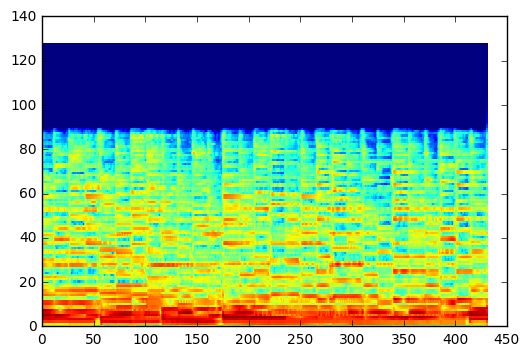

In [8]:
S = librosa.feature.melspectrogram(signal, sr=rate, n_mels=128)
log_S = librosa.logamplitude(S, ref_power=np.max)
plt.pcolormesh(log_S)

# Loading the data

In [9]:
data = []
for i in range(1, 8):
    path = os.path.join(BP, "spectrograms/spectrograms{}.pcl".format(i))
    with open(path, "rb") as fin:
        data.extend(list(np.load(fin)))
data = np.array(data)

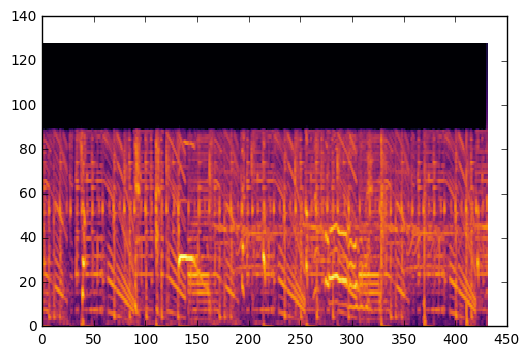

In [10]:
plt.pcolormesh(data[11999], cmap='inferno')

In [11]:
with open(os.path.join(BP, "train_genres.txt"), "r") as fin:
    genres = np.array(fin.read().splitlines())

In [12]:
genres[10000]

'hardcore'

In [13]:
print("ALL GENRES\n")
for genre in sorted(np.unique(genres), key=lambda x: -np.sum(genres == x)):
    print("{} {}".format(genre, np.sum(genres == genre)))
print("\nTotal: {}".format(len(np.unique(genres))))

ALL GENRES

pop 4204
rock 1198
electronics 772
rap 717
dance 601
estrada 506
alternative 445
shanson 428
rusrock 427
rusrap 367
soundtrack 301
folk 220
metal 202
rnb 158
other 132
jazz 124
punk 112
classical 106
relax 94
house 92
trance 78
indie 72
ukrrock 47
latinfolk 43
children 39
reggae 37
soul 36
blues 34
eastern 34
eurofolk 26
country 22
holiday 20
lounge 20
disco 19
bard 18
rusfolk 18
newage 16
techno 16
dnb 15
dubstep 15
bollywood 14
prog 14
spiritual 13
conjazz 12
vocal 12
urban 10
funk 9
rnr 9
spoken 8
asiapop 7
hardcore 7
modern 7
industrial 6
meditation 6
reggaeton 6
experimental 5
musical 4
ska 4
tradjazz 3
african 2
balkan 2
jewish 2
newwave 2
sport 2
amerfolk 1
celtic 1
dub 1

Total: 67


In [14]:
from collections import defaultdict
X = data[:12000]
X_kaggle = data[12000:]
mapping = defaultdict(lambda: len(mapping))
y = np.array(list(map(lambda x: mapping[x], genres)))
inv_mapping = dict(zip(mapping.values(), mapping.keys()))
perm = np.random.permutation(np.arange(len(X)))
X = X[perm]
y = y[perm]

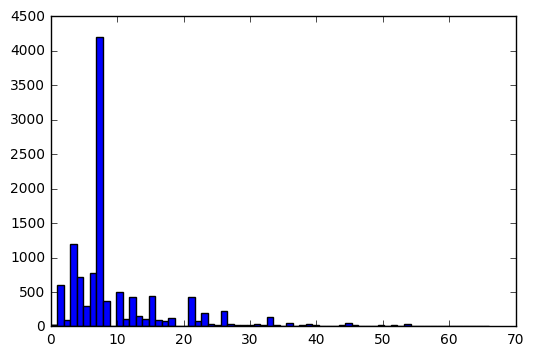

In [15]:
plt.hist(y, bins=67)
plt.show()

# Nearest Neighbors genre classification

Перемешаем датасет - используйте `np.random.permutation` и индексацию `a[np.random.permutation]`.

Разобьем датасет на трейн и валидацию 80/20%. Выкинем частоты с индексом больше 90, так как они все равно нули.

In [16]:
X_train = X[:10000, :90, :]
X_valid = X[10000:, :90, :]

y_train = y[:10000]
y_valid = y[10000:]

Попробуем поклассифицировать жанры методом ближайших соседей.

In [71]:
clf = KNeighborsClassifier(n_jobs=8, algorithm='kd_tree', n_neighbors=15)
clf = clf.fit(X_train.reshape(10000, -1), y_train)
y_val_pred = clf.predict(X_valid.reshape(2000, -1))

print(accuracy_score(y_valid, y_val_pred))

0.156


# Fully-Connected Neural Nets

Использовать нейросети - это хорошая идея, давайте начнем с полносвязных сетей.

In [80]:
g = tf.Graph()
with g.as_default():
    input_X = tf.placeholder(dtype=tf.float32, shape=(None, 90, 431))
    input_Y = tf.placeholder(dtype=tf.int32, shape=(None,))
    is_training = tf.placeholder(dtype=tf.bool, shape=())
    nn = flatten(input_X)
    nn = fully_connected(nn, 512)
    nn = fully_connected(nn, 512)
    logits = fully_connected(nn, 512)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, input_Y))
    y_predict = tf.cast(tf.argmax(logits, 1), tf.int32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(input_Y, y_predict), tf.float32))
    
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [17]:
def batch(X_train, y_train, batch_size, max_time_steps=None):
    time_steps = X_train.shape[2]
    if max_time_steps is None:
        max_time_steps = time_steps
    perm = np.random.permutation(np.arange(len(X_train)), )
    for i in range(len(X_train) / batch_size):
        indices = perm[i*batch_size:(i+1)*batch_size]
        X_batch = []
        y_batch = []
        for i, true_idx in zip(range(batch_size), indices):
            start_index = np.random.randint(0, time_steps - max_time_steps + 1)
            X_batch.append(X_train[true_idx, :, start_index:start_index+max_time_steps])
            y_batch.append(y_train[true_idx])
        yield np.array(X_batch), np.array(y_batch)

In [18]:
def predict(X, sess):
    results = []
    i = 0
    start_time = time.time()
    while i < len(X):
        X_batch = X[i:min(i + batch_size, len(X))]
        i += batch_size
        results.extend(sess.run(y_predict, feed_dict={input_X: X_batch, is_training: False}))
    print("PREDICT DONE, TIME {}".format(time.time() - start_time))
    return results

def train(num_epochs=10, batch_size=32, batch_max_time_steps=None, print_predicted=False):
    f = open("log.txt", "w")
    with g.as_default():
        sess = tf.Session()
        tf.initialize_all_variables().run(session=sess)
        for epoch in range(num_epochs):
            epoch_loss, epoch_acc, idx, start_time = 0, 0, 0, time.time()
            for X_batch, y_batch in batch(X_train, y_train, batch_size, batch_max_time_steps):
                batch_loss, batch_accuracy, _ = sess.run([loss, accuracy, optimizer], feed_dict={input_X: X_batch, input_Y: y_batch, is_training: True})
                epoch_loss += batch_loss
                epoch_acc += batch_accuracy
                idx += 1
            epoch_loss /= idx
            epoch_acc /= idx
            string = "EPOCH {} DONE, AVG LOSS {}, AVG ACC {}, TIME {}".format(epoch, epoch_loss, epoch_acc, time.time() - start_time)
            print(string)
            print(string, file=f)
            f.flush()
            valid_acc = 0
            valid_loss = 0
            idx = 0
            start_time = time.time()
            for X_batch, y_batch in batch(X_valid, y_valid, batch_size):
                valid_loss_delta, valid_acc_delta, y_pred, logits_batch = sess.run([loss, accuracy, y_predict, logits], feed_dict={input_X: X_batch, input_Y: y_batch,
                                                                                                                                   is_training: False})
                valid_acc += valid_acc_delta
                valid_loss += valid_loss_delta
                idx += 1
                if idx == 1 and print_predicted:
                    print(y_pred)
            valid_acc /= idx
            valid_loss /= idx
            string = "VALID LOSS {} ACC {}, TIME {}".format(valid_loss, valid_acc, time.time() - start_time)
            print(string)
            print(string, file=f)
            f.flush()
    f.close()
    return sess

In [99]:
train(10, 512)

EPOCH 0 DONE, AVG LOSS 2096.6263769, AVG ACC 0.0368009868421, TIME 1.31538701057
VALID LOSS 1551.51253255 ACC 0.00260416666667, TIME 0.176368951797
EPOCH 1 DONE, AVG LOSS 627.478603965, AVG ACC 0.0741159539474, TIME 1.30704188347
VALID LOSS 239.505208333 ACC 0.0169270833333, TIME 0.179238080978
EPOCH 2 DONE, AVG LOSS 189.713161469, AVG ACC 0.104029605263, TIME 1.3252120018
VALID LOSS 63.3678894043 ACC 0.001953125, TIME 0.177028179169
EPOCH 3 DONE, AVG LOSS 15.3722071899, AVG ACC 0.107730263158, TIME 1.32693791389
VALID LOSS 6.20388650894 ACC 0.341145833333, TIME 0.175112009048
EPOCH 4 DONE, AVG LOSS 6.18077087402, AVG ACC 0.352590460526, TIME 1.3229329586
VALID LOSS 6.14992078145 ACC 0.34375, TIME 0.179836034775
EPOCH 5 DONE, AVG LOSS 6.11845751813, AVG ACC 0.351973684211, TIME 1.33483886719
VALID LOSS 6.08165645599 ACC 0.339192708333, TIME 0.173896074295
EPOCH 6 DONE, AVG LOSS 6.04241215555, AVG ACC 0.352693256579, TIME 1.31410694122
VALID LOSS 5.99686940511 ACC 0.340494791667, TIME 0

# Convolution Neural Nets

In [25]:
g = tf.Graph()
with g.as_default():
    input_X = tf.placeholder(dtype=tf.float32, shape=(None, 90, None))
    input_Y = tf.placeholder(dtype=tf.int32, shape=(None,))
    is_training = tf.placeholder(dtype=tf.bool, shape=())
    nn = tf.expand_dims(input_X, 3)
    nn = conv2d(nn, 64, [4, 4])
    nn = max_pool2d(nn, [2, 2], [2, 2])
    nn = conv2d(nn, 128, [4, 4])
    nn = max_pool2d(nn, [2, 2], [2, 2])
    nn = conv2d(nn, 256, [4, 4])
    nn = max_pool2d(nn, [2, 2], [2, 2])
    nn = conv2d(nn, 256, [4, 4])
    nn = tf.reduce_max(nn, [2])
    nn = flatten(nn)
    #nn = fully_connected(nn, 1024, weights_regularizer=l2_regularizer(1.0))
    logits = fully_connected(nn, 67, weights_regularizer=l2_regularizer(0.8), activation_fn=None)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, input_Y))
    y_predict = tf.cast(tf.argmax(logits, 1), tf.int32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(input_Y, y_predict), tf.float32))
    
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [26]:
sess = train(30, 64, 400, True)

EPOCH 0 DONE, AVG LOSS 2.9416960325, AVG ACC 0.341446314103, TIME 48.4888541698
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
VALID LOSS 2.67574923269 ACC 0.332157258065, TIME 3.37700510025
EPOCH 1 DONE, AVG LOSS 2.49083655232, AVG ACC 0.354667467949, TIME 47.4899189472
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
VALID LOSS 2.53818467356 ACC 0.340221774194, TIME 3.04973602295
EPOCH 2 DONE, AVG LOSS 2.33457639737, AVG ACC 0.386518429487, TIME 47.564650774
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 4 7 7 7 7 7 4 7 7 7 4 7 3 3 7 7 7 7 7
 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7 6 7 4 7 7 3 7 7 7 7 7 3]
VALID LOSS 2.47133548029 ACC 0.368447580645, TIME 3.04477787018
EPOCH 3 DONE, AVG LOSS 2.2137254446, AVG ACC 0.404647435897, TIME 47.576777935
[ 7  7  7  3  7  7  7  7  7  7  3  7  7  3  4  7  5  3  7  3  3  7  7  7  7
  7  4  7  7  7 12 

KeyboardInterrupt: 

[u'Conv/weights:0', u'Conv/biases:0', u'fully_connected/weights:0', u'fully_connected/biases:0', u'fully_connected_1/weights:0', u'fully_connected_1/biases:0', u'beta1_power:0', u'beta2_power:0', u'Conv/weights/Adam:0', u'Conv/weights/Adam_1:0', u'Conv/biases/Adam:0', u'Conv/biases/Adam_1:0', u'fully_connected/weights/Adam:0', u'fully_connected/weights/Adam_1:0', u'fully_connected/biases/Adam:0', u'fully_connected/biases/Adam_1:0', u'fully_connected_1/weights/Adam:0', u'fully_connected_1/weights/Adam_1:0', u'fully_connected_1/biases/Adam:0', u'fully_connected_1/biases/Adam_1:0']


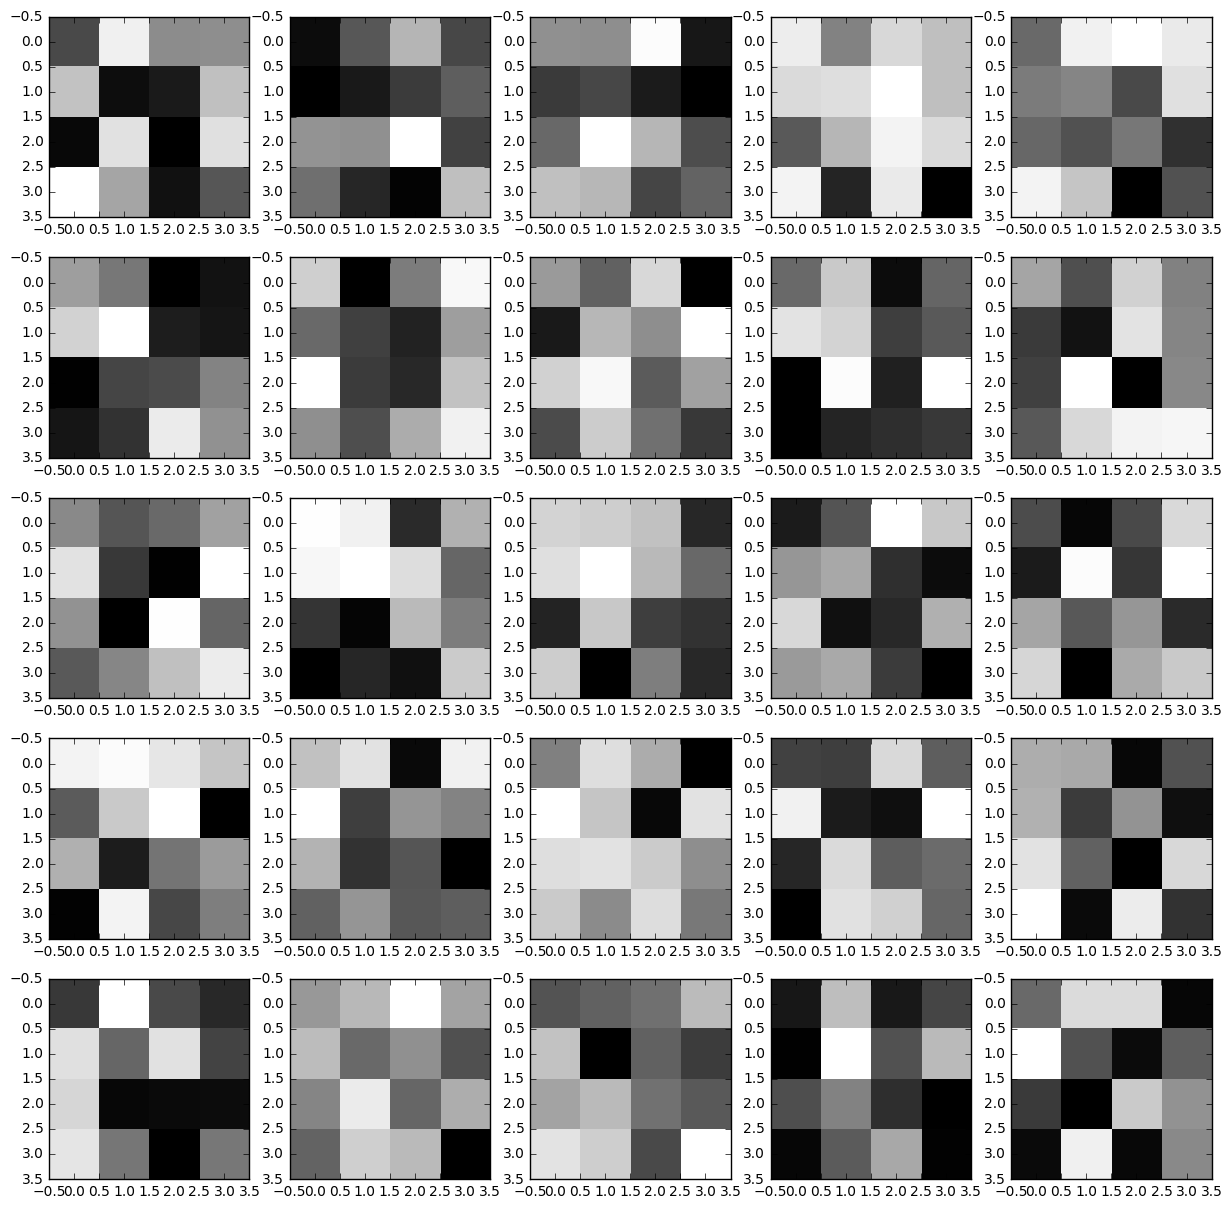

In [135]:
with g.as_default():
    print([v.name for v in tf.all_variables()])
    W = [v for v in tf.all_variables() if v.name == "Conv/weights:0"][0]
    W_val = sess.run(W)
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    for i in range(5):
        for j in range(5):
            axes[i, j].imshow(W_val[:, :, 0, i * 5 + j], interpolation='nearest', cmap='gray')
    plt.show()

Давайте нарисуем каждый второй фильтр - можете ли вы проинтерпретировать эти фильтры?

# Maps of tracks by SVD and tSNE

Хорошая идея посмотреть, как полученое представление отображается с сохранением относительных расстояний на плоскость. Используйте tSNE или PCA.

Help: https://lts2.epfl.ch/blog/perekres/category/visualizing-hidden-structures-in-datasets-using-deep-learning/

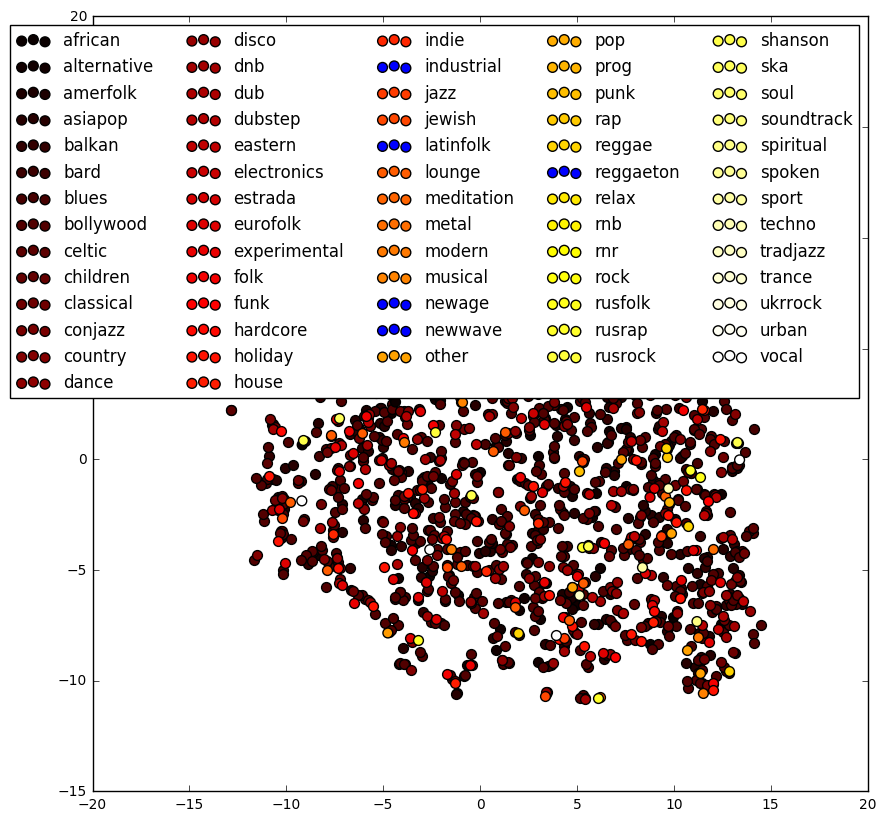

In [151]:
from sklearn.manifold import TSNE
all_last_hidden = []
with g.as_default():
    for (test_batch, test_labels) in batch(X_train, y_train, batch_size):
        if len(test_batch) < batch_size:
            break
        feedDict = {input_X: test_batch, input_Y: test_labels}
        last_hidden = sess.run(nn, feed_dict=feedDict).reshape((32, 1024))
        all_last_hidden.extend(last_hidden)
all_last_hidden = np.array(all_last_hidden)
model = TSNE(n_components=2, random_state=42)
X_tsne = model.fit_transform(all_last_hidden[:2000]) 
plt.figure(figsize=(10,10), dpi=500)
colors = cm.hot(np.linspace(0, 1, 67))

for idx, genre in enumerate(unique(genres)):
    idx_ = np.where(y_train[:2000] == idx)
    pylab.scatter(X_tsne[idx_,0], X_tsne[idx_,1], c=colors[idx], cmap=cm.hot, label=genre, s=50)
pylab.legend(loc=0, ncol=5)